In [1]:
import numpy as np
import pandas as pd
from torch import nn
from sysidentpy.metrics import mean_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.neural_network import NARXNN

from sysidentpy.basis_function._basis_function import Polynomial, Fourier
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import (
    compute_residues_autocorrelation,
    compute_cross_correlation,
)
from sysidentpy.utils.narmax_tools import regressor_code
import torch
from sysidentpy.utils.display_results import results

In [45]:
torch.cuda.is_available()

False

In [46]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [47]:
def generate_siso_data(n, test_size, noise_level):
    np.random.seed(4)
    u = np.random.randint(0,2, size=n)  #generate the exogenous inputs of size n, you can use np.random.randint()
    y = np.zeros(n)  #generate a zero vector of size n
    e = np.random.normal(0,noise_level)
    a1 = 0.5
    a2 = -0.3
    b1 = 0.7
    b2 = -0.2
    for t in range(2, n):
        y[t] = a1*y[t-1] + a2*y[t-2] + b1*u[t-1] + b2*u[t-2] + e
        y_test = y[0:round(n*test_size)]
        u_test = u[0:round(n*test_size)]
        y_train = y[round(n*test_size):n]
        u_train = u[round(n*test_size):n]
    return y_train, u_train, y_test, u_test

y_train, u_train, y_test, u_test = generate_siso_data(2000, 0.2, 0.1)

In [48]:
basis_function = Polynomial(degree=1)

narx_net = NARXNN(
    ylag=2,
    xlag=2,
    basis_function=basis_function,
    model_type="NARMAX",
    loss_func="mse_loss",
    optimizer="Adam",
    epochs=2000,
    verbose=False,
    device="cuda",
    optim_params={
        "betas": (0.9, 0.999),
        "eps": 1e-05,
    },  # optional parameters of the optimizer
)

/home/s193864/miniconda3/envs/module3_env/lib/python3.11/site-packages/sysidentpy/neural_network/narx_nn.py:156: UserWarning: No CUDA available. We set the device as CPU
  self.device = self._check_cuda(device)


In [49]:
regressors = regressor_code(
    X=u_train.reshape(-1,1),
    xlag=2,
    ylag=2,
    model_type="NARMAX",
    model_representation="neural_network",
    basis_function=basis_function,
)

In [50]:


n_features = regressors.shape[0]  # the number of features of the NARX net
n_features


4

In [51]:


regressors


array([[1001],
       [1002],
       [2001],
       [2002]])

#### Building the neural network


In [52]:
class NARX(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(n_features, 30)
        self.lin2 = nn.Linear(30, 30)
        self.lin3 = nn.Linear(30, 1)
        self.tanh = nn.Tanh()

    def forward(self, xb):
        z = self.lin(xb)
        z = self.tanh(z)
        z = self.lin2(z)
        z = self.tanh(z)
        z = self.lin3(z)
        return z

##### Passing the defined network to our NARXNN estimator

In [53]:
narx_net.net = NARX()

In [54]:
if device == "cuda": narx_net.net.to(torch.device("cuda"))

##### Fit and predict

In [55]:
narx_net.fit(X=u_train.reshape(-1,1), y=y_train.reshape(-1,1), X_test=u_test.reshape(-1,1), y_test=y_test.reshape(-1,1))

In [56]:
yhat = narx_net.predict(X=u_test.reshape(-1,1), y=y_test.reshape(-1,1))

##### Results

MSE:  5.620581736598541e-06


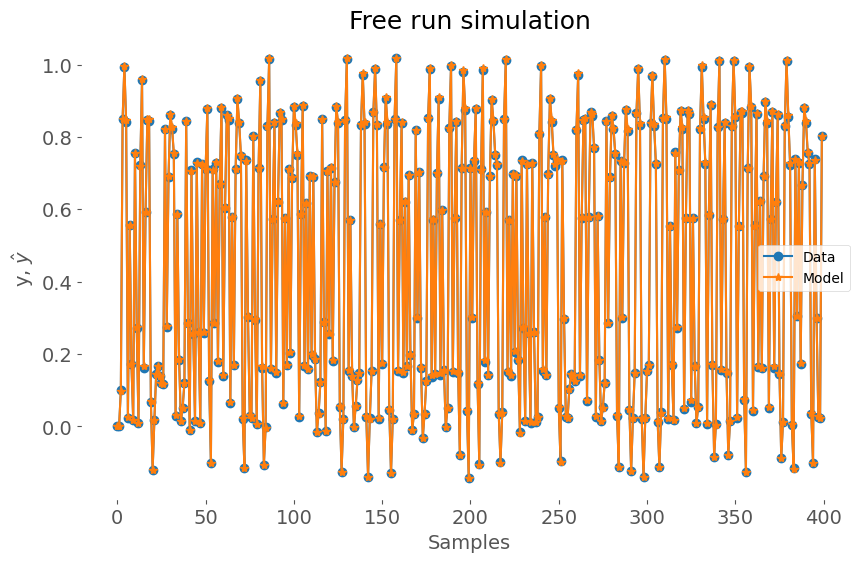

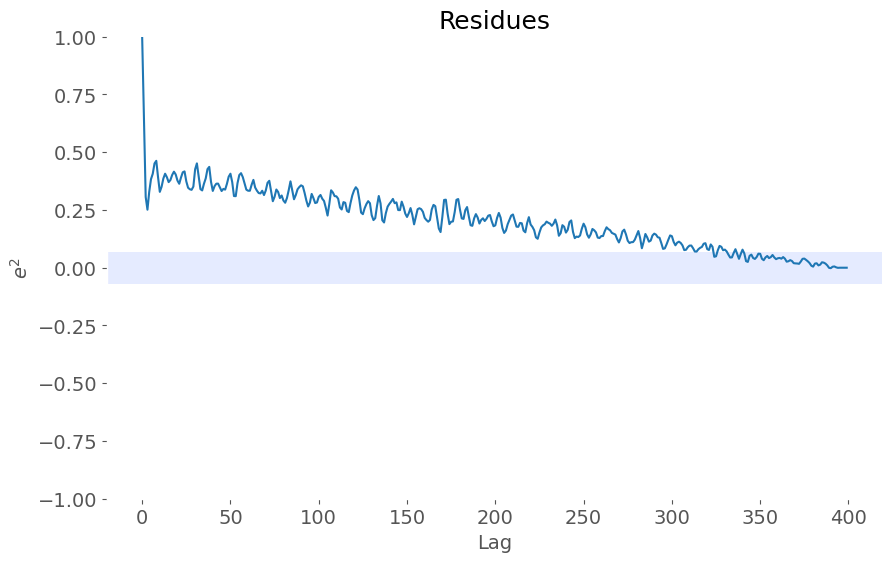

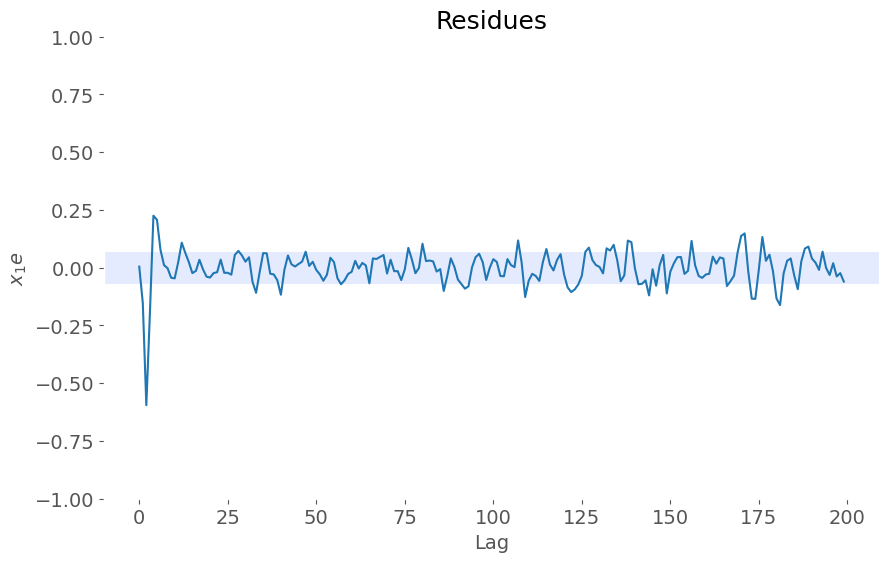

In [57]:
print("MSE: ", mean_squared_error(y_test.reshape(-1,1), yhat.reshape(-1,1)))
plot_results(y=y_test.reshape(-1,1), yhat=yhat.reshape(-1,1), n=1000, style='ggplot')
ee = compute_residues_autocorrelation(y_test.reshape(-1,1), yhat.reshape(-1,1))
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$", style='ggplot')
x1e = compute_cross_correlation(y_test.reshape(-1,1), yhat.reshape(-1,1), u_test.reshape(-1,1))
plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$", style='ggplot')